# Wykorzystanie rozkładów macierzy do rozwiązywania oznaczonych układów równań

Poznane na wykładzie rozkłady (faktoryzacje) macierzy możemy wykorzystać do rozwiązywania układów równań liniowych. Dzięki wykorzystaniu specjalnych własności macierzy występujących w rozkładzie jesteśmy w stanie w łatwiejszy sposób odwrócić macierz i tym samym zminimalizować błąd.


In [1]:
import numpy as np
import scipy
import time
from scipy.linalg import lu, qr, solve_triangular
import matplotlib.pyplot as plt

**Zadanie 1.**

Rozważmy układ równań $Ax=b$, w którym:
* $A$ jest macierzą Hilberta o wymiarach 15x15.
* $A$ jest macierzą wartości losowych z przedziału $[0,100]$ o wymiarach 100x100,  1000x1000 i 1000000x1000000.
* $b$ jest wektorem wartości losowych, odpowiednio, o wymiarach 15x1, 100x1, 1000x1 i 1000000x1.

1. Oblicz współczynnik uwarunkowania macierzy $A$ i oceń jej uwarunkowanie.
2. Rozwiąż układ równań następującymi metodami:
    * z użyciem jawnej odwrotności $A$.
    * korzystając z rozkładu [LU](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lu.html) (uwaga na macierz permutacji!):
        * z wykorzystaniem odwrotności L i U.
        * z użyciem jedynie odwrotności i metody podstawiania wstecznego.
    * korzystając z rozkładu [QR](https://numpy.org/doc/stable/reference/generated/numpy.linalg.qr.html):
        * z wykorzystaniem odwrotności Q i R.
        * z użyciem jedynie odwrotności Q i metody podstawiania wstecznego.
    * za pomocą jednej z metod iteracyjnych z poprzedniego ćwiczenia.
    * za pomocą metody [`solve`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html) z pakietu NumPy.
3. Porównaj otrzymane wyniki. W tym celu oblicz normy z residuuów otrzymanych dla każdego z rozwiązań. Którą z metod cechuje najwyższa dokladność?
4. Przeprowadź porównanie wydajności ww. metod. Zmierz czas wykonania każdej metody. Aby otrzymać bardziej sensowny wynik należy powtórzyć obliczenia w pętli (np. 100 lub 1000 razy) i uśrednić wynik. Do pomiaru czasu wykonania możesz wykorzystać pakiet `time`.

Wskazówka: Do rozwiązania układu z macierzą trójkątną możesz wykorzystać funkcję [`scipy.linalg.solve_triangular`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_triangular.html).

        
        


In [2]:
m = [
    scipy.linalg.hilbert(15), 
    np.random.rand(100, 100)*100, 
    np.random.rand(1000, 1000)*100,
    #np.random.rand(1000000, 1000000)*100 dont think its possible
]
b_vectors = [
    np.random.rand(15)*100,
    np.random.rand(100)*100,
    np.random.rand(1000)*100
    #np.random.rand(1000000)*100 too much bro
]

def compute_residual_lu_inv(A, b):
    P, L, U = lu(A)
    b_permuted = P.T @ b
    y = np.linalg.inv(L) @ b_permuted
    x_lu_inv = np.linalg.inv(U) @ y
    #x_lu_inv = np.linalg.inv(U) @ np.linalg.inv(L) @ P.T @ b
    return np.linalg.norm(A @ x_lu_inv - b)

def compute_residual_lu_sub(A, b):
    P, L, U = lu(A)
    b_permuted = P.T @ b
    y = solve_triangular(L, b_permuted, lower=True)
    x_lu_sub = solve_triangular(U, y, lower=False)
    return np.linalg.norm(A @ x_lu_sub - b)

def compute_residual_qr_inv(A, b):
    Q, R = qr(A)
    y = Q.T @ b
    x_qr_inv = np.linalg.inv(R) @ y
    return np.linalg.norm(A @ x_qr_inv - b)

def compute_residual_qr_subs(A, b):
    Q, R = qr(A)
    x_qr_sub = solve_triangular(R, Q.T @ b, lower=False) # qr returns R as upper
    return np.linalg.norm(A @ x_qr_sub - b)

for A, b in zip(m, b_vectors):
    print("condition number for matrix of shape", A.shape, ":", np.linalg.cond(A))
    # 1 Direct inverse
    print("    residual norm for inverse:", np.linalg.norm(np.dot(np.linalg.inv(A), b) - b))

    # 2a LU decomposition with inverse of L and U
    print(f"    residual norm for LU with inverse of L and U: {compute_residual_lu_inv(A, b):.2e}")

    # 2b: LU with forward/backward substitution
    print(f"    residual norm for LU with substitution: {compute_residual_lu_sub(A, b):.2e}")

    # 3 QR with inv of Q & R
    print(f"    residual norm for QR with inv: {compute_residual_qr_inv(A, b):.2e}")

    # 4 QR with substitution
    print(f"    residual norm for QR with substitution: {compute_residual_qr_subs(A, b):.2e}")

    # 5 np solve
    print(f"    residual norm for np.solve: {np.linalg.norm(A @ np.linalg.solve(A, b) - b):.2e}")

print("qr seems to be the best(with substitution)")

for A, b_vec in zip(m, b_vectors):
    print(f"Matrix shape: {A.shape}")
    
    num_iter = 100
    print(f"num of iterations: {num_iter}")
    
    start = time.time()
    for _ in range(num_iter):
        tmp = np.linalg.norm(np.dot(np.linalg.inv(A), b_vec) - b_vec)
    print(f"  Direct inverse: {(time.time() - start) / num_iter:.6f} s")

    start = time.time()
    for _ in range(num_iter):
        tmp = compute_residual_lu_inv(A, b_vec)
    print(f"  LU (inverse): {(time.time() - start) / num_iter:.6f} s")

    start = time.time()
    for _ in range(num_iter):
        tmp = compute_residual_lu_sub(A, b_vec)
    print(f"  LU (substitution): {(time.time() - start) / num_iter:.6f} s")

    start = time.time()
    for _ in range(num_iter):
        tmp = compute_residual_qr_inv(A, b_vec)
    print(f"  QR (inverse): {(time.time() - start) / num_iter:.6f} s")

    start = time.time()
    for _ in range(num_iter):
        tmp = compute_residual_qr_subs(A, b_vec)
    print(f"  QR (substitution): {(time.time() - start) / num_iter:.6f} s")
    
    start = time.time()
    for _ in range(num_iter):
        tmp = np.linalg.norm(A @ np.linalg.solve(A, b_vec) - b_vec)
    print(f"  np.solve: {(time.time() - start) / num_iter:.6f} s")

print("np.solve is the fastest, then LU substitution")

condition number for matrix of shape (15, 15) : 4.2386885262972096e+17
    residual norm for inverse: 2.711767561201301e+18
    residual norm for LU with inverse of L and U: 2.45e+02
    residual norm for LU with substitution: 1.43e+02
    residual norm for QR with inv: 2.99e+02
    residual norm for QR with substitution: 2.43e+02
    residual norm for np.solve: 1.01e+02
condition number for matrix of shape (100, 100) : 21132.46784815938
    residual norm for inverse: 559.0430025086198
    residual norm for LU with inverse of L and U: 1.34e-11
    residual norm for LU with substitution: 4.33e-12
    residual norm for QR with inv: 7.83e-12
    residual norm for QR with substitution: 6.84e-12
    residual norm for np.solve: 5.08e-12
condition number for matrix of shape (1000, 1000) : 45742.1291667993
    residual norm for inverse: 1803.8598144393204
    residual norm for LU with inverse of L and U: 1.38e-09
    residual norm for LU with substitution: 3.15e-10
    residual norm for QR wit

# Interpolacja

**Zadanie 2.**

Przeprowadź interpolacje poniższych funkcji $f(x)$ za pomocą wielomianów interpolacyjnych Lagrange'a ([`scipy.interpolate.lagrange`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.lagrange.html)). Stwórz wykresy funkcji interpolacyjnych i zaznacz na nich punkty, w ktorych dokonano oceny wartości funkcji.

Pierwsza funkcja:

* $f(0) = 1$,
* $f(0.25) = 1.64872$,
* $f(0.5) = 2.71828$,
* $f(0.75) = 4.48169.$

Oblicz $f(0.43)$.

Druga funkcja:

* $f_2(0.1) = 0.62049958$,
* $f_2(0.2) = -0.28398668$,
* $f_2(0.3) = 0.00660095$,
* $f_2(0.4) = 0.24842440$. 

Oblicz $f_2(0.25)$.

Evaluated polynomial at 0.43: 2.360604734079999
Evaluated polynomial at 0.25: -0.21033722187499881


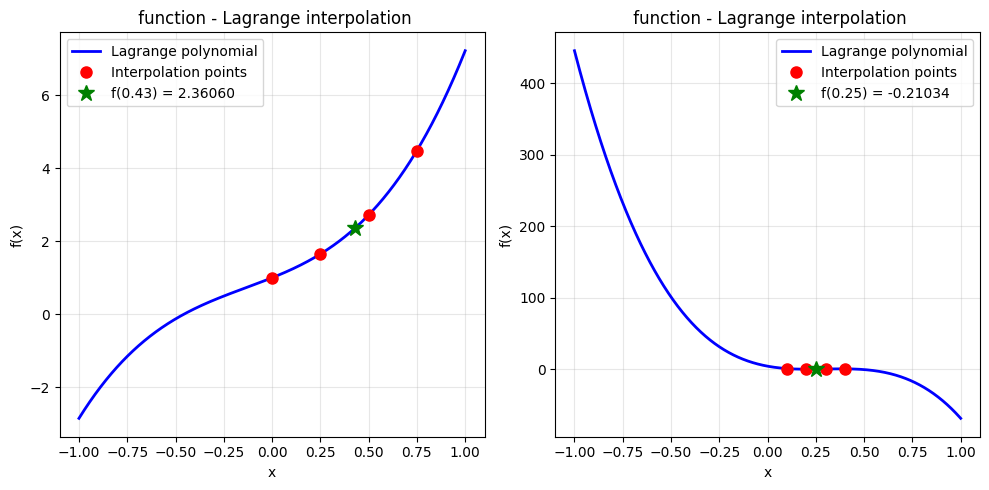

In [3]:
x = [[0, 0.25, 0.5, 0.75], [0.1,0.2,0.3,0.4]]
y = [[1, 1.64872, 2.71828, 4.48169], [0.62049958, -0.28398668, 0.00660095, 0.24842440]]
val = [0.43, 0.25]

plt.figure(figsize=(10, 5))
for xi, yi, val, i in zip(x, y, val, range(2)):
    poly = scipy.interpolate.lagrange(xi, yi)

    print(f"Evaluated polynomial at {val}: {poly(val)}")
    x_plot = np.linspace(-1, 1, 1000)
    y_plot = poly(x_plot)

    plt.subplot(1, 2, i+1)
    plt.plot(x_plot, y_plot, 'b-', label='Lagrange polynomial', linewidth=2)
    plt.plot(xi, yi, 'ro', markersize=8, label='Interpolation points')
    plt.plot(val, poly(val), 'g*', markersize=12, label=f'f({val}) = {poly(val):.5f}')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title(f' function - Lagrange interpolation')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

***Zadanie 3.***

Rozważmy funkcję $f(x)=\frac{1}{25x^2+1}$. 

Przeprowadź interpolacje funkcji $f$ w przedziale $[-2,2]$ wielomianem Lagrange'a oraz funkcjami sklejanymi 3 stopnia w:
- 21 równoodległych węzłach,
- 21 węzłach [Czebyszewa](https://pl.wikipedia.org/wiki/Węzły_Czebyszewa).

**Wskazówka** Interpolację funkcjami sklejanymi możesz przeprowadzić za pomocą funkcji [`interp1d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d).

Umieść wielomian interpolacyjny, oryginalną funkcję $f$ oraz węzly interpolacyjne na wspólnym wykresie (jeden wykres dla metody Lagrange'a oraz jeden dla funkcji sklejanych). Porównaj otrzymane rezultaty. Przeprowadź te same działania dla przedziału $x\in[-5,5]$. Jakie problemy możesz zauważyć na otrzymanych wykresach?

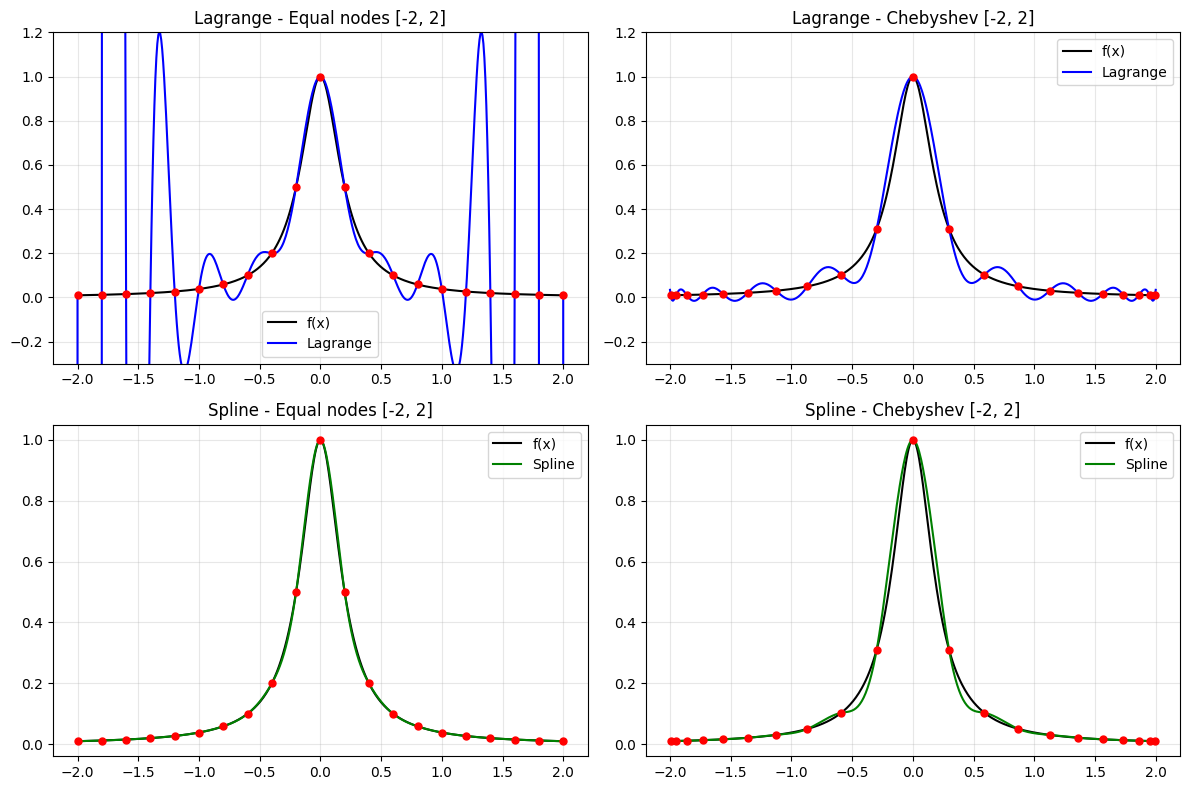

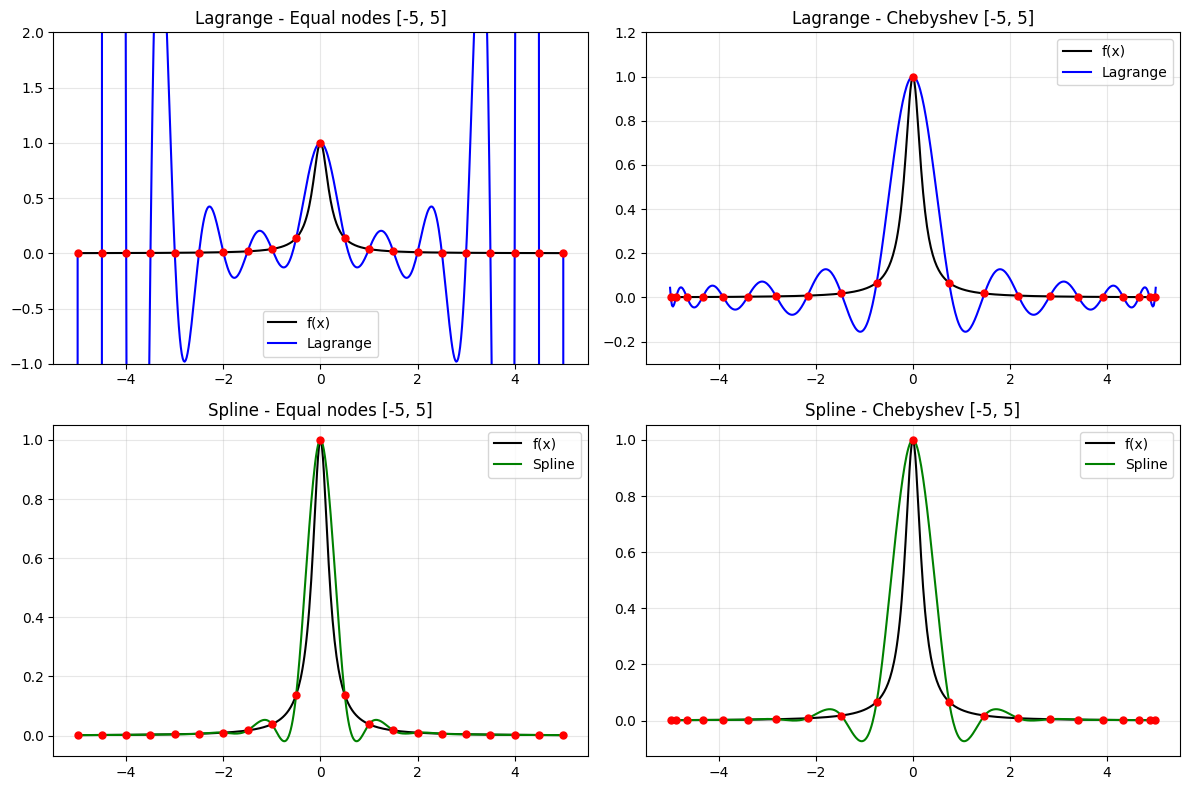

Lagrange with equal nodes shows oscillations (Runge phenomenon)
Chebyshev nodes reduce this problem
Splines work well regardless of node type


In [4]:
from scipy.interpolate import lagrange, interp1d

def f(x):
    return 1 / (25 * x**2 + 1)

def chebyshev_nodes(n, a, b):
    i = np.arange(1, n + 1)
    nodes = np.cos((2 * i - 1) * np.pi / (2 * n))
    return (a + b) / 2 + (b - a) / 2 * nodes

n_nodes = 21

# Interval [-2, 2]
x_equal_1 = np.linspace(-2, 2, n_nodes)
x_cheb_1 = np.sort(chebyshev_nodes(n_nodes, -2, 2))
x_plot_1 = np.linspace(-2, 2, 500)

poly_equal_1 = lagrange(x_equal_1, f(x_equal_1))
poly_cheb_1 = lagrange(x_cheb_1, f(x_cheb_1))
spline_equal_1 = interp1d(x_equal_1, f(x_equal_1), kind='cubic') # sklejone 3 stopnia
spline_cheb_1 = interp1d(x_cheb_1, f(x_cheb_1), kind='cubic', bounds_error=False)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(x_plot_1, f(x_plot_1), 'k-', label='f(x)')
axes[0, 0].plot(x_plot_1, poly_equal_1(x_plot_1), 'b-', label='Lagrange')
axes[0, 0].plot(x_equal_1, f(x_equal_1), 'ro', markersize=5)
axes[0, 0].set_title('Lagrange - Equal nodes [-2, 2]')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_ylim([-0.3, 1.2])

axes[0, 1].plot(x_plot_1, f(x_plot_1), 'k-', label='f(x)')
axes[0, 1].plot(x_plot_1, poly_cheb_1(x_plot_1), 'b-', label='Lagrange')
axes[0, 1].plot(x_cheb_1, f(x_cheb_1), 'ro', markersize=5)
axes[0, 1].set_title('Lagrange - Chebyshev [-2, 2]')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_ylim([-0.3, 1.2])

axes[1, 0].plot(x_plot_1, f(x_plot_1), 'k-', label='f(x)')
axes[1, 0].plot(x_plot_1, spline_equal_1(x_plot_1), 'g-', label='Spline')
axes[1, 0].plot(x_equal_1, f(x_equal_1), 'ro', markersize=5)
axes[1, 0].set_title('Spline - Equal nodes [-2, 2]')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

axes[1, 1].plot(x_plot_1, f(x_plot_1), 'k-', label='f(x)')
axes[1, 1].plot(x_plot_1, spline_cheb_1(x_plot_1), 'g-', label='Spline')
axes[1, 1].plot(x_cheb_1, f(x_cheb_1), 'ro', markersize=5)
axes[1, 1].set_title('Spline - Chebyshev [-2, 2]')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Interval [-5, 5]
x_equal_2 = np.linspace(-5, 5, n_nodes)
x_cheb_2 = np.sort(chebyshev_nodes(n_nodes, -5, 5))
x_plot_2 = np.linspace(-5, 5, 500)

poly_equal_2 = lagrange(x_equal_2, f(x_equal_2))
poly_cheb_2 = lagrange(x_cheb_2, f(x_cheb_2))
spline_equal_2 = interp1d(x_equal_2, f(x_equal_2), kind='cubic')
spline_cheb_2 = interp1d(x_cheb_2, f(x_cheb_2), kind='cubic', bounds_error=False)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(x_plot_2, f(x_plot_2), 'k-', label='f(x)')
axes[0, 0].plot(x_plot_2, poly_equal_2(x_plot_2), 'b-', label='Lagrange')
axes[0, 0].plot(x_equal_2, f(x_equal_2), 'ro', markersize=5)
axes[0, 0].set_title('Lagrange - Equal nodes [-5, 5]')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_ylim([-1, 2])

axes[0, 1].plot(x_plot_2, f(x_plot_2), 'k-', label='f(x)')
axes[0, 1].plot(x_plot_2, poly_cheb_2(x_plot_2), 'b-', label='Lagrange')
axes[0, 1].plot(x_cheb_2, f(x_cheb_2), 'ro', markersize=5)
axes[0, 1].set_title('Lagrange - Chebyshev [-5, 5]')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_ylim([-0.3, 1.2])

axes[1, 0].plot(x_plot_2, f(x_plot_2), 'k-', label='f(x)')
axes[1, 0].plot(x_plot_2, spline_equal_2(x_plot_2), 'g-', label='Spline')
axes[1, 0].plot(x_equal_2, f(x_equal_2), 'ro', markersize=5)
axes[1, 0].set_title('Spline - Equal nodes [-5, 5]')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

axes[1, 1].plot(x_plot_2, f(x_plot_2), 'k-', label='f(x)')
axes[1, 1].plot(x_plot_2, spline_cheb_2(x_plot_2), 'g-', label='Spline')
axes[1, 1].plot(x_cheb_2, f(x_cheb_2), 'ro', markersize=5)
axes[1, 1].set_title('Spline - Chebyshev [-5, 5]')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Lagrange with equal nodes shows oscillations (Runge phenomenon)")
print("Chebyshev nodes reduce this problem")
print("Splines work well regardless of node type")

***Zadanie 4.***

Kierowca jadący z miasta A do miasta B, zauważywszy na drodze fotoradar, zaczął gwałtownie hamować. Przebieg jego położenia, zarejestrowany przez nawigację, pokazano w poniższej tabeli. Wiedząc, że radar znajduje się w punkcie o współrzędnej 79.6 m, oszacuj kiedy kierowca minął fotoradar (w tym celu skorzystaj z jednej z metod z laboratorium 3) oraz z jaką prędkością wtedy jechał (wykorzystaj relację drogi i prędkości znaną z fizyki). 

|czas \[s\]|położenie \[m\]|
|--|--|
|0.0|0.0|
|1.0|42.7|
|2.0|73.2|
|3.0|92.5|

Time when driver passed the radar: 2.2758 s.
btw converged in: 6 iter.
Speed at radar: 21.68 m/s = 78.05 km/h


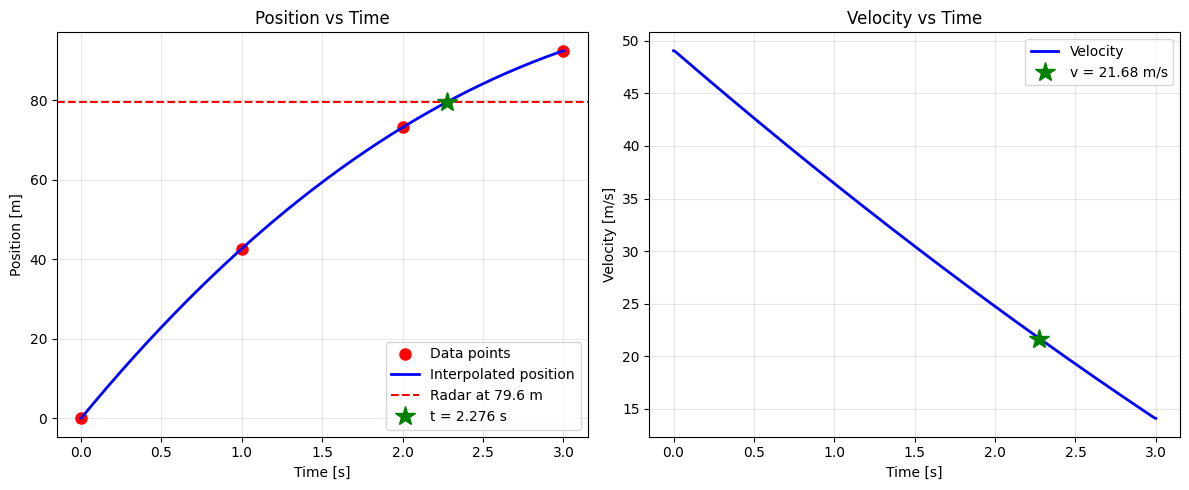

Driver passed the radar at t = 2.2758 s with speed 21.68 m/s (78.05 km/h)


In [ ]:
def sieczne(f, x0, x1, tol=1e-7, max_iter=1000): # copied from lab3
    for iteration in range(max_iter):
        fx0 = f(x0)
        fx1 = f(x1)
        
        if abs(fx1 - fx0) < 1e-15:
            raise ValueError(f"f(x1) - f(x0) zbyt blisko zera: f({x0}) = {fx0}, f({x1}) = {fx1}")
        
        x_new = x1 - fx1 * (x1 - x0) / (fx1 - fx0)
        
        if abs(fx1) < tol or abs(x_new - x1) < tol:
            return x_new, iteration + 1
        
        x0, x1 = x1, x_new
    
    return x1, max_iter

t = np.array([0.0, 1.0, 2.0, 3.0]) # getting data
s = np.array([0.0, 42.7, 73.2, 92.5])
radar_pos = 79.6

f = interp1d(t, s, kind='cubic') # function of pos over time
def equation(time):              # equation to solve
    return f(time) - radar_pos

t_radar, iterations = sieczne(equation, 2.0, 3.0) # robimy sieczne w przedziale [2, 3]

print(f"Time when driver passed the radar: {t_radar:.4f} s.")
print(f"btw converged in: {iterations} iter.")

# calculating speed at that moment
# v(t) = ds/dt - so we can approximate using numerical derivative
dt = 0.001
v = (f(t_radar + dt) - f(t_radar - dt)) / (2 * dt) # central difference

print(f"Speed at radar: {v:.2f} m/s = {v * 3.6:.2f} km/h")

# Visualization
t_plot = np.linspace(0, 3, 300)
s_plot = f(t_plot)

plt.figure(figsize=(12, 5))

# Position vs time
plt.subplot(1, 2, 1)
plt.plot(t, s, 'ro', markersize=8, label='Data points')
plt.plot(t_plot, s_plot, 'b-', linewidth=2, label='Interpolated position')
plt.axhline(y=radar_pos, color='r', linestyle='--', label=f'Radar at {radar_pos} m')
plt.plot(t_radar, radar_pos, 'g*', markersize=15, label=f't = {t_radar:.3f} s')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.title('Position vs Time')
plt.legend()
plt.grid(alpha=0.3)

# Velocity vs time
plt.subplot(1, 2, 2)
velocities = np.gradient(s_plot, t_plot) # can easily find speed this way(computes central diffs)
plt.plot(t_plot, velocities, 'b-', linewidth=2, label='Velocity')
plt.plot(t_radar, v, 'g*', markersize=15, label=f'v = {v:.2f} m/s')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.title('Velocity vs Time')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Driver passed the radar at t = {t_radar:.4f} s with speed {v:.2f} m/s ({v * 3.6:.2f} km/h)")

**Zadanie dla zainteresowanych programowaniem funkcyjnym w Pythonie**

Stwórz funkcję znajdującą wielomian interpolacyjny metodą Lagrange'a. Funkcja powinna przyjmować dwie listy:
* listę argumentów ($x$-ów)
* listę wartości ($y$-ów).  


Po wykonaniu obliczeń funkcja powinna zwracać wielomian w postaci obiektu typu **funkcja** (a nie `numpy.Polynomial`).

**Wskazówka** Wykorzystaj wyrażenia *lambda*. Dla ułatwienia możesz się też posłużyć pakietami `operator` i `functools`.


Testing custom Lagrange interpolation:
f(0.43) = 2.36060
f(0) = 1.00000
f(0.5) = 2.71828

Comparison with scipy.interpolate.lagrange:
Custom: f(0.43) = 2.36060
Scipy:  f(0.43) = 2.36060


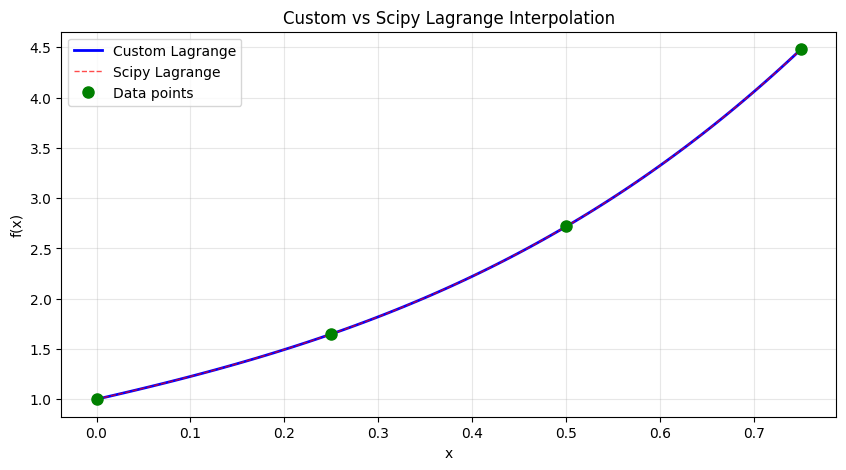

as we can see, they're the same


In [7]:
from functools import reduce
from operator import mul

def lagrange_interpolation(x_nodes, y_nodes):
    """
    Creates Lagrange interpolation polynomial as a function.
    
    Args:
        x_nodes: list of x coordinates
        y_nodes: list of y coordinates
    
    Returns:
        function that evaluates the Lagrange polynomial at any point
    """
    n = len(x_nodes)
    
    # Create basis polynomials L_i(x)
    def L_i(i):
        # L_i(x) = product of (x - x_j) / (x_i - x_j) for j != i
        return lambda x: reduce(mul,  # caly sens zadania
                                [(x - x_nodes[j]) / (x_nodes[i] - x_nodes[j]) 
                                 for j in range(n) if j != i], 
                                1)
    
    # Lagrange polynomial P(x) = sum of y_i * L_i(x)
    return lambda x: sum(y_nodes[i] * L_i(i)(x) for i in range(n))

# Test with the first function from Zadanie 2
x_test = [0, 0.25, 0.5, 0.75]
y_test = [1, 1.64872, 2.71828, 4.48169]

poly_func = lagrange_interpolation(x_test, y_test)

print("Testing custom Lagrange interpolation:")
print(f"f(0.43) = {poly_func(0.43):.5f}")
print(f"f(0) = {poly_func(0):.5f}")
print(f"f(0.5) = {poly_func(0.5):.5f}")

# Compare with scipy
poly_scipy = scipy.interpolate.lagrange(x_test, y_test)
print(f"\nComparison with scipy.interpolate.lagrange:")
print(f"Custom: f(0.43) = {poly_func(0.43):.5f}")
print(f"Scipy:  f(0.43) = {poly_scipy(0.43):.5f}")

# Visualize
x_plot = np.linspace(0, 0.75, 100)
y_custom = [poly_func(x) for x in x_plot]
y_scipy = poly_scipy(x_plot)

plt.figure(figsize=(10, 5))
plt.plot(x_plot, y_custom, 'b-', label='Custom Lagrange', linewidth=2)
plt.plot(x_plot, y_scipy, 'r--', label='Scipy Lagrange', linewidth=1, alpha=0.7)
plt.plot(x_test, y_test, 'go', markersize=8, label='Data points')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Custom vs Scipy Lagrange Interpolation')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print('as we can see, they\'re the same')